In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [8]:
# Load processed dataset
print("Loading feature-engineered dataset...")
df = pd.read_csv('../dataset/Students_Social_Media_Addiction_Feature_Engineered.csv')

# Remove string/categorical columns that can't be converted to float
categorical_columns = ['Gender', 'Academic_Level', 'Country', 'Most_Used_Platform', 
                       'Relationship_Status', 'Affects_Academic_Performance']
id_columns = ['Student_ID']

# Check which columns actually exist in the dataset and drop them
columns_to_drop = []
for col in categorical_columns + id_columns:
    if col in df.columns:
        columns_to_drop.append(col)

# Drop the categorical columns
if columns_to_drop:
    print(f"Dropping non-numeric columns: {columns_to_drop}")
    df = df.drop(columns=columns_to_drop)

# Split target and features
X = df.drop('Addicted_Score', axis=1)
y = df['Addicted_Score']

print(f"Dataset shape: {df.shape}")
print(f"Features: {X.shape[1]}")

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Enhanced evaluation function
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    return {
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'MAE': mae
    }

Loading feature-engineered dataset...
Dropping non-numeric columns: ['Gender', 'Academic_Level', 'Country', 'Most_Used_Platform', 'Relationship_Status', 'Affects_Academic_Performance', 'Student_ID']
Dataset shape: (705, 18)
Features: 17



=== SCENARIO 1: FEATURE SELECTION OPTIMIZATION ===

Training model WITHOUT feature selection
MSE: 0.1306
RMSE: 0.3614
R² Score: 0.9478
MAE: 0.1346

Top 10 features by importance:
                        Feature  Importance
3           Mental_Health_Score    0.448115
15       Mental_Health_Risk_Low    0.386557
4   Conflicts_Over_Social_Media    0.110115
10            Lifestyle_Balance    0.015402
2         Sleep_Hours_Per_Night    0.008665
9               SM_Impact_Score    0.007922
1         Avg_Daily_Usage_Hours    0.007266
0                           Age    0.004882
8   Relationship_Status_Encoded    0.003672
6                Gender_Encoded    0.002615

Finding optimal number of features...

Testing with k=1 features
MSE: 0.2497
RMSE: 0.4997
R² Score: 0.9002
MAE: 0.3152

Testing with k=2 features
MSE: 0.1091
RMSE: 0.3303
R² Score: 0.9564
MAE: 0.2165

Testing with k=3 features
MSE: 0.1291
RMSE: 0.3593
R² Score: 0.9484
MAE: 0.2109

Testing with k=4 features
MSE: 0.1853
RMSE: 0.4305
R²

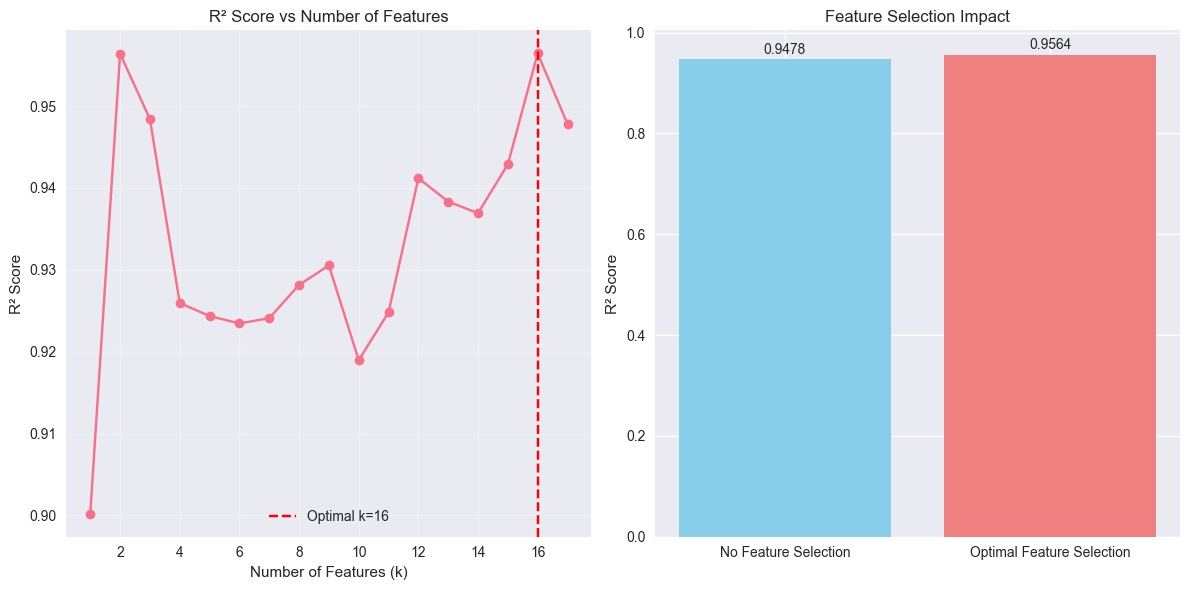

Using the optimal 16 features for next scenario


In [9]:
# ================================
# SCENARIO 1: Optimizing Feature Selection
# ================================
print("\n=== SCENARIO 1: FEATURE SELECTION OPTIMIZATION ===")
results_scenario1 = {}

# Without feature selection - baseline
print("\nTraining model WITHOUT feature selection")
model_no_fs = RandomForestRegressor(random_state=42)
model_no_fs.fit(X_train, y_train)
y_pred_no_fs = model_no_fs.predict(X_test)
results_no_fs = evaluate_model(y_test, y_pred_no_fs)
results_scenario1['No Feature Selection'] = results_no_fs
results_scenario1['No Feature Selection']['n_features'] = X_train.shape[1]

# Feature importance from Random Forest
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model_no_fs.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 features by importance:")
print(feature_importances.head(10))

# Iterate through different k values to find optimal feature count
print("\nFinding optimal number of features...")
max_features = min(X.shape[1], 20)  # Test up to all features or max 20
k_values = range(1, max_features + 1)
k_results = []

for k in k_values:
    print(f"\nTesting with k={k} features")
    selector = SelectKBest(f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    results = evaluate_model(y_test, y_pred)
    results['n_features'] = k
    k_results.append(results)

# Find optimal k (features count)
optimal_k = max(range(len(k_results)), key=lambda i: k_results[i]['R2'])
optimal_k_value = k_values[optimal_k]
print(f"\nOptimal number of features: {optimal_k_value}")

# Use optimal k for feature selection
print(f"\nTraining model with optimal feature selection (k={optimal_k_value})")
selector_optimal = SelectKBest(f_regression, k=optimal_k_value)
X_train_selected = selector_optimal.fit_transform(X_train, y_train)
X_test_selected = selector_optimal.transform(X_test)

# Get names of selected features
selected_features = X.columns[selector_optimal.get_support()]
print(f"Selected features: {selected_features.tolist()}")

model_fs = RandomForestRegressor(random_state=42)
model_fs.fit(X_train_selected, y_train)
y_pred_fs = model_fs.predict(X_test_selected)
results_fs = evaluate_model(y_test, y_pred_fs)
results_fs['n_features'] = optimal_k_value
results_scenario1['Optimal Feature Selection'] = results_fs

# Determine which approach is better
best_approach_s1 = 'Optimal Feature Selection' if results_fs['R2'] > results_no_fs['R2'] else 'No Feature Selection'
print(f"\nBest approach for Scenario 1: {best_approach_s1}")

# Visualization of feature selection results
plt.figure(figsize=(12, 6))

# Plot R² vs number of features
plt.subplot(1, 2, 1)
r2_scores = [r['R2'] for r in k_results]
plt.plot(k_values, r2_scores, 'o-')
plt.axvline(x=optimal_k_value, color='r', linestyle='--', label=f'Optimal k={optimal_k_value}')
plt.xlabel('Number of Features (k)')
plt.ylabel('R² Score')
plt.title('R² Score vs Number of Features')
plt.grid(True, alpha=0.3)
plt.legend()

# Bar chart comparing no feature selection vs optimal
plt.subplot(1, 2, 2)
plt.bar(['No Feature Selection', 'Optimal Feature Selection'], 
        [results_no_fs['R2'], results_fs['R2']], color=['skyblue', 'lightcoral'])
plt.ylabel('R² Score')
plt.title('Feature Selection Impact')
for i, v in enumerate([results_no_fs['R2'], results_fs['R2']]):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()

# Use best approach for next scenario
if best_approach_s1 == 'Optimal Feature Selection':
    X_train_best_s1 = X_train_selected
    X_test_best_s1 = X_test_selected
    print(f"Using the optimal {optimal_k_value} features for next scenario")
else:
    X_train_best_s1 = X_train
    X_test_best_s1 = X_test
    print(f"Using all {X_train.shape[1]} features for next scenario")



=== SCENARIO 2: NORMALIZATION IMPACT ===

Training model WITHOUT normalization
MSE: 0.1090
RMSE: 0.3302
R² Score: 0.9564
MAE: 0.1284

Training model WITH normalization
MSE: 0.1085
RMSE: 0.3295
R² Score: 0.9566
MAE: 0.1275

Best approach for Scenario 2: With Normalization


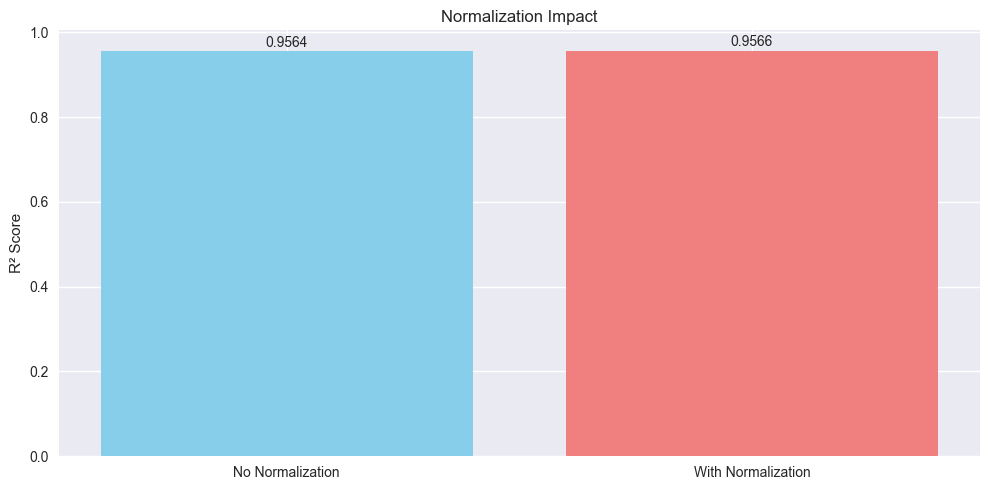

Using normalized features for next scenario


In [10]:
# ================================
# SCENARIO 2: With vs Without Normalization
# ================================
print("\n=== SCENARIO 2: NORMALIZATION IMPACT ===")
results_scenario2 = {}

# Without normalization (using best from scenario 1)
print("\nTraining model WITHOUT normalization")
model_no_norm = RandomForestRegressor(random_state=42)
model_no_norm.fit(X_train_best_s1, y_train)
y_pred_no_norm = model_no_norm.predict(X_test_best_s1)
results_no_norm = evaluate_model(y_test, y_pred_no_norm)
results_scenario2['No Normalization'] = results_no_norm

# With normalization
print("\nTraining model WITH normalization")
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train_best_s1)
X_test_normalized = scaler.transform(X_test_best_s1)

model_norm = RandomForestRegressor(random_state=42)
model_norm.fit(X_train_normalized, y_train)
y_pred_norm = model_norm.predict(X_test_normalized)
results_norm = evaluate_model(y_test, y_pred_norm)
results_scenario2['With Normalization'] = results_norm

# Determine which approach is better
best_approach_s2 = 'With Normalization' if results_norm['R2'] > results_no_norm['R2'] else 'No Normalization'
print(f"\nBest approach for Scenario 2: {best_approach_s2}")

# Bar chart comparing normalization impact
plt.figure(figsize=(10, 5))
plt.bar(['No Normalization', 'With Normalization'], 
        [results_no_norm['R2'], results_norm['R2']], color=['skyblue', 'lightcoral'])
plt.ylabel('R² Score')
plt.title('Normalization Impact')
for i, v in enumerate([results_no_norm['R2'], results_norm['R2']]):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()

# Use the best approach for next scenario
if best_approach_s2 == 'With Normalization':
    X_train_best_s2 = X_train_normalized
    X_test_best_s2 = X_test_normalized
    print("Using normalized features for next scenario")
else:
    X_train_best_s2 = X_train_best_s1
    X_test_best_s2 = X_test_best_s1
    print("Using non-normalized features for next scenario")




=== SCENARIO 3: HYPERPARAMETER TUNING IMPACT ===

Training model WITHOUT hyperparameter tuning
MSE: 0.1085
RMSE: 0.3295
R² Score: 0.9566
MAE: 0.1275

Training model WITH hyperparameter tuning
This may take a few minutes...
Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
MSE: 0.1242
RMSE: 0.3525
R² Score: 0.9504
MAE: 0.1353

Best approach for Scenario 3: No Tuning


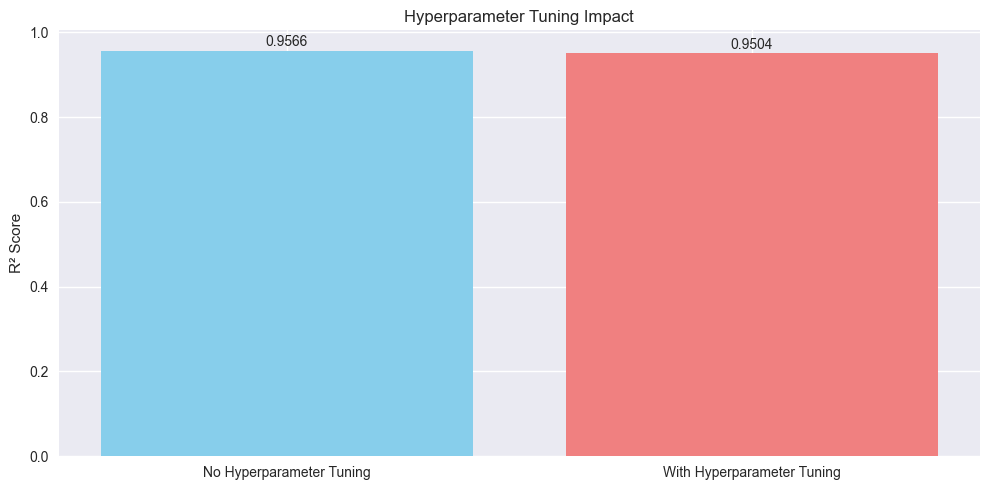

In [11]:
# ================================
# SCENARIO 3: With vs Without Hyperparameter Tuning
# ================================
print("\n=== SCENARIO 3: HYPERPARAMETER TUNING IMPACT ===")
results_scenario3 = {}

# Without hyperparameter tuning (default parameters)
print("\nTraining model WITHOUT hyperparameter tuning")
model_no_tune = RandomForestRegressor(random_state=42)
model_no_tune.fit(X_train_best_s2, y_train)
y_pred_no_tune = model_no_tune.predict(X_test_best_s2)
results_no_tune = evaluate_model(y_test, y_pred_no_tune)
results_scenario3['No Tuning'] = results_no_tune

# With hyperparameter tuning
print("\nTraining model WITH hyperparameter tuning")
print("This may take a few minutes...")

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_best_s2, y_train)
print(f"\nBest parameters: {grid_search.best_params_}")

model_tune = grid_search.best_estimator_
y_pred_tune = model_tune.predict(X_test_best_s2)
results_tune = evaluate_model(y_test, y_pred_tune)
results_scenario3['With Tuning'] = results_tune

# Determine which approach is better
best_approach_s3 = 'With Tuning' if results_tune['R2'] > results_no_tune['R2'] else 'No Tuning'
print(f"\nBest approach for Scenario 3: {best_approach_s3}")

# Bar chart comparing hyperparameter tuning impact
plt.figure(figsize=(10, 5))
plt.bar(['No Hyperparameter Tuning', 'With Hyperparameter Tuning'], 
        [results_no_tune['R2'], results_tune['R2']], color=['skyblue', 'lightcoral'])
plt.ylabel('R² Score')
plt.title('Hyperparameter Tuning Impact')
for i, v in enumerate([results_no_tune['R2'], results_tune['R2']]):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')
plt.tight_layout()
plt.show()




=== FINAL SUMMARY ===
Dataset: Students_Social_Media_Addiction_Feature_Engineered.csv
Best for Feature Selection: Optimal Feature Selection
  - Using 16 features: Age, Avg_Daily_Usage_Hours, Sleep_Hours_Per_Night, Mental_Health_Score, Conflicts_Over_Social_Media, Adequate_Sleep, Gender_Encoded, Academic_Level_Encoded, Relationship_Status_Encoded, SM_Impact_Score, Lifestyle_Balance, Usage_Category_Medium, Usage_Category_High, Usage_Category_Very High, Mental_Health_Risk_Medium, Mental_Health_Risk_Low
Best for Normalization: With Normalization
Best for Hyperparameter Tuning: No Tuning

Improvements:
Feature Selection: 0.91% change in R² score
Normalization: 0.02% change in R² score
Hyperparameter Tuning: 0.00% change in R² score

Detailed Results Summary:
            No Feature Selection  Optimal Feature Selection  No Normalization  \
MAE                       0.1346                     0.1284            0.1284   
MSE                       0.1306                     0.1090            0.

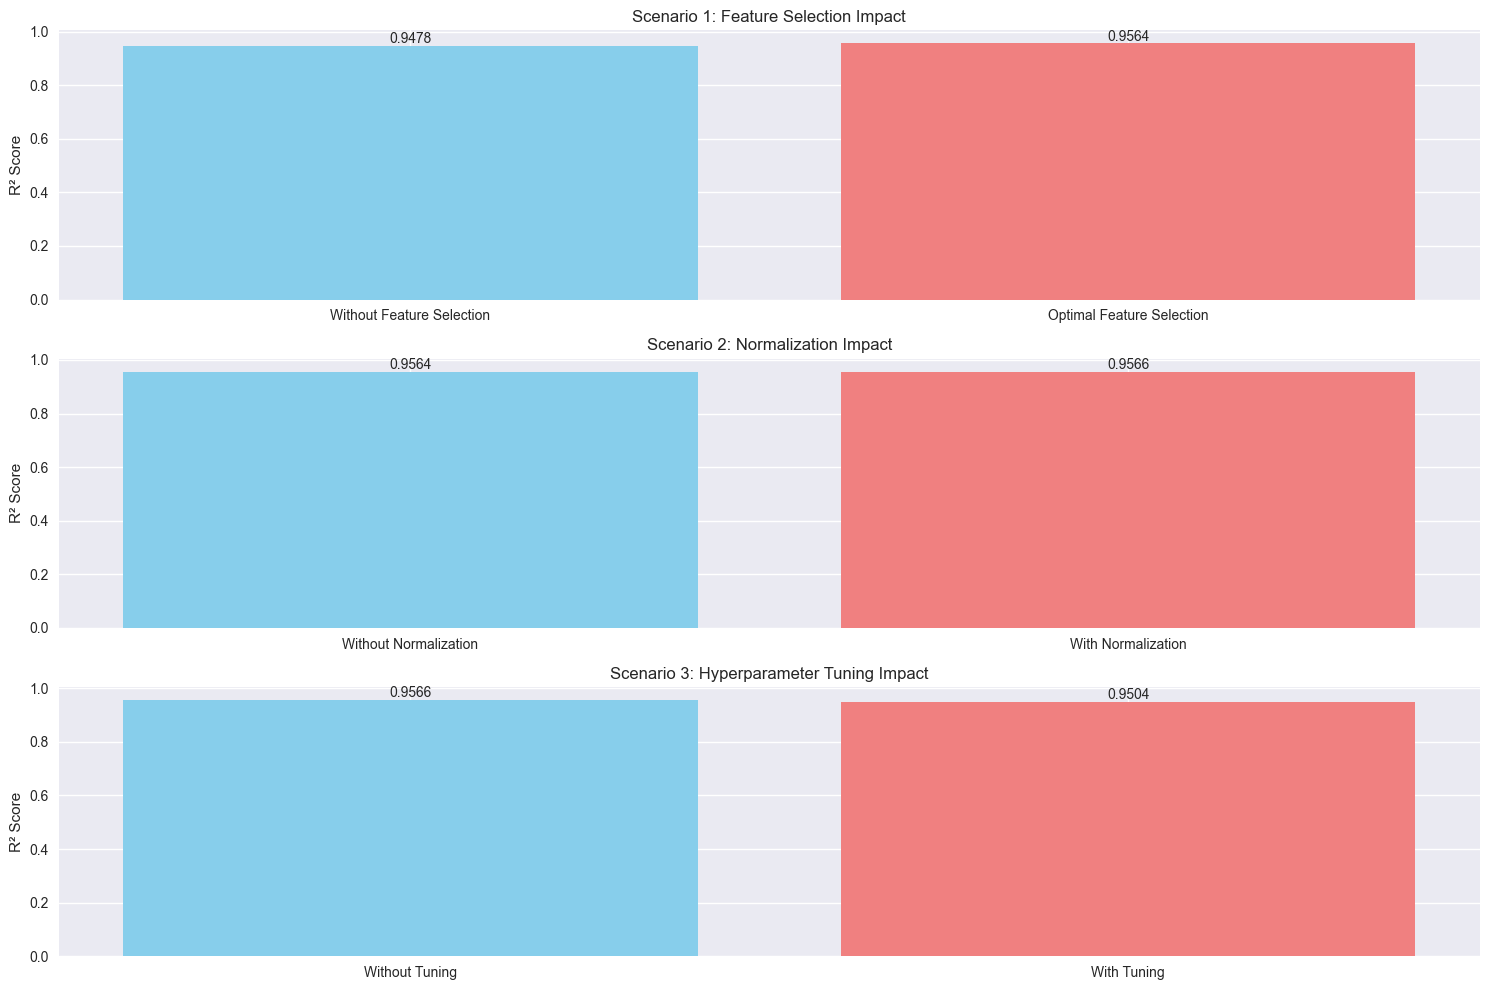


=== FINAL MODEL EVALUATION ===
Final model performance:
MSE: 0.1085
RMSE: 0.3295
R² Score: 0.9566
MAE: 0.1275
Model saved to ../models/random_forest_model.pkl
Preprocessing information saved


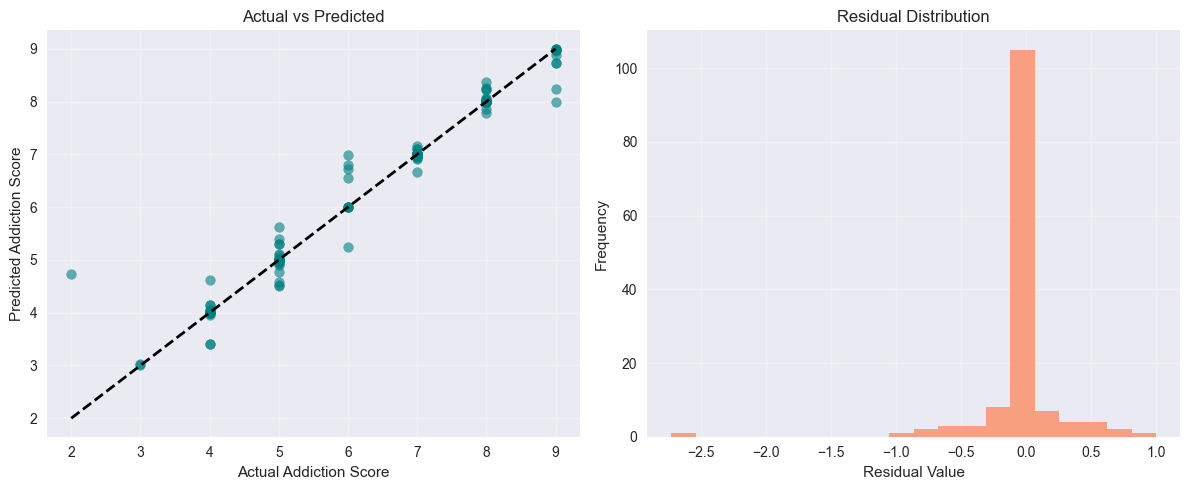

In [12]:
# ================================
# FINAL SUMMARY
# ================================
print("\n=== FINAL SUMMARY ===")
print(f"Dataset: Students_Social_Media_Addiction_Feature_Engineered.csv")
print(f"Best for Feature Selection: {best_approach_s1}")
if best_approach_s1 == 'Optimal Feature Selection':
    print(f"  - Using {optimal_k_value} features: {', '.join(selected_features)}")
else:
    print(f"  - Using all {X.shape[1]} features")
    
print(f"Best for Normalization: {best_approach_s2}")
print(f"Best for Hyperparameter Tuning: {best_approach_s3}")

if best_approach_s3 == 'With Tuning':
    print(f"  - Best parameters: {grid_search.best_params_}")

# Calculate improvements
fs_improvement = ((results_scenario1[best_approach_s1]['R2'] - results_scenario1['No Feature Selection']['R2']) / 
                 results_scenario1['No Feature Selection']['R2'] * 100)

norm_improvement = ((results_scenario2[best_approach_s2]['R2'] - results_scenario2['No Normalization']['R2']) / 
                   results_scenario2['No Normalization']['R2'] * 100)

tuning_improvement = ((results_scenario3[best_approach_s3]['R2'] - results_scenario3['No Tuning']['R2']) / 
                     results_scenario3['No Tuning']['R2'] * 100)

print(f"\nImprovements:")
print(f"Feature Selection: {fs_improvement:.2f}% change in R² score")
print(f"Normalization: {norm_improvement:.2f}% change in R² score")
print(f"Hyperparameter Tuning: {tuning_improvement:.2f}% change in R² score")

# Create a summary table
results_df = pd.DataFrame({
    'No Feature Selection': pd.Series(results_scenario1['No Feature Selection']),
    'Optimal Feature Selection': pd.Series(results_scenario1['Optimal Feature Selection']),
    'No Normalization': pd.Series(results_scenario2['No Normalization']),
    'With Normalization': pd.Series(results_scenario2['With Normalization']),
    'No Tuning': pd.Series(results_scenario3['No Tuning']),
    'With Tuning': pd.Series(results_scenario3['With Tuning'])
})

print("\nDetailed Results Summary:")
print(results_df.round(4))

# Visualize all scenario results
plt.figure(figsize=(15, 10))

# Plot 1: Feature Selection
plt.subplot(3, 1, 1)
plt.bar(['Without Feature Selection', 'Optimal Feature Selection'],
        [results_scenario1['No Feature Selection']['R2'], results_scenario1['Optimal Feature Selection']['R2']],
        color=['skyblue', 'lightcoral'])
plt.title('Scenario 1: Feature Selection Impact')
plt.ylabel('R² Score')
for i, v in enumerate([results_scenario1['No Feature Selection']['R2'], results_scenario1['Optimal Feature Selection']['R2']]):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

# Plot 2: Normalization
plt.subplot(3, 1, 2)
plt.bar(['Without Normalization', 'With Normalization'],
        [results_scenario2['No Normalization']['R2'], results_scenario2['With Normalization']['R2']],
        color=['skyblue', 'lightcoral'])
plt.title('Scenario 2: Normalization Impact')
plt.ylabel('R² Score')
for i, v in enumerate([results_scenario2['No Normalization']['R2'], results_scenario2['With Normalization']['R2']]):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

# Plot 3: Hyperparameter Tuning
plt.subplot(3, 1, 3)
plt.bar(['Without Tuning', 'With Tuning'],
        [results_scenario3['No Tuning']['R2'], results_scenario3['With Tuning']['R2']],
        color=['skyblue', 'lightcoral'])
plt.title('Scenario 3: Hyperparameter Tuning Impact')
plt.ylabel('R² Score')
for i, v in enumerate([results_scenario3['No Tuning']['R2'], results_scenario3['With Tuning']['R2']]):
    plt.text(i, v + 0.01, f"{v:.4f}", ha='center')

plt.tight_layout()
plt.show()

# Final model evaluation
print("\n=== FINAL MODEL EVALUATION ===")
# Get the best model from all scenarios
if best_approach_s3 == 'With Tuning':
    final_model = model_tune
    y_pred_final = y_pred_tune
else:
    final_model = model_no_tune
    y_pred_final = y_pred_no_tune

print("Final model performance:")
final_results = evaluate_model(y_test, y_pred_final)

# Save the best model and preprocessing pipeline
import joblib

# Create models directory if it doesn't exist
import os
if not os.path.exists('../models'):
    os.makedirs('../models')

# Save best model
model_filename = f'../models/random_forest_model.pkl'
joblib.dump(final_model, model_filename)
print(f"Model saved to {model_filename}")

# Save preprocessing information
preproc_info = {
    'feature_selection': best_approach_s1,
    'selected_features': selected_features.tolist() if best_approach_s1 == 'Optimal Feature Selection' else None,
    'normalization': best_approach_s2 == 'With Normalization',
    'best_params': grid_search.best_params_ if best_approach_s3 == 'With Tuning' else None
}

if best_approach_s1 == 'Optimal Feature Selection':
    joblib.dump(selector_optimal, '../models/feature_selector.pkl')
    
if best_approach_s2 == 'With Normalization':
    joblib.dump(scaler, '../models/scaler.pkl')

joblib.dump(preproc_info, '../models/preproc_info.pkl')
print("Preprocessing information saved")

# Final visualization - actual vs predicted
plt.figure(figsize=(12, 5))

# Scatter plot of actual vs predicted values
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_final, alpha=0.6, color='teal')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Addiction Score')
plt.ylabel('Predicted Addiction Score')
plt.title('Actual vs Predicted')
plt.grid(True, alpha=0.3)

# Histogram of residuals
plt.subplot(1, 2, 2)
residuals = y_test - y_pred_final
plt.hist(residuals, bins=20, alpha=0.7, color='coral')
plt.xlabel('Residual Value')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()